## Win/Loss Betting Model


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

Obtain results of teams within the past year

In [107]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv')
h_matches['Date'] = pd.to_datetime(h_matches['Date'])
h_teams = pd.read_csv('hltv_csv/teams.csv')
h_teams = h_teams.set_index('ID')
h_teams.loc[7723, 'Name'] = 'Morior Invictus'
h_teams.loc[8478, 'Name'] = 'ex-Nitrious'

In [108]:
MIN_DATE = dt.datetime(2017,1,1)
FILTER_TEAMS = ['OpTic', 'SK', 'Cloud9', 'Liquid', 'Luminosity', 'Misfits', 'Renegades', 'Immortals', 
                'Splyce', 'compLexity', 'Rogue', 'Ghost', 'CLG', 'NRG'] # ESL PL NA/ecs
FILTER_TEAMS = FILTER_TEAMS + ['BIG', 'LDLC', 'mousesports', 'EnVyUs', 'NiP', 'Virtus.pro', 
                               'Astralis', 'G2', 'GODSENT', 'Heroic', 'fnatic', 'NiP', 'G2', 'Heroic'] # ESL PL EU/ecs
#FILTER_TEAMS = ['Virtus.pro', 'FlipSid3', 'eXtatus', 'AGO', 'Fragsters', 'Gambit', 'PRIDE', '1337HUANIA', 
#                'VITALIS', 'Epsilon', 'CHAOS', 'Crowns', 'MK', 'Japaleno', 'Not Academy', 'aAa', 'Space Soldiers',
#                'Singularity', 'Nexus', 'Invictus Aquilas', 'Spirit', 'Kinguin', 'Seed', 'Endpoint', 'iGame.com', 'TEAM5',
#                'ALTERNATE aTTaX'] #mdl eu
#FILTER_TEAMS = ['Gale Force', 'FRENCH CANADIANS', 'Mythic', 'GX', 'Beacon', 'Torqued', 'Rise Nation', 'Denial', 'subtLe', 
#               'SoaR', 'Muffin Lightning', 'Iceberg', 'ex-Nitrious', 'Adaptation', 'Morior Invictus', 'Naventic', 'CheckSix', 'Good People'
#               , 'LFAO', 'CLG Academy', 'Ambition', 'Mostly Harmless', 'Gorilla Core', 'ex-Nitrious', 'ANTI ECO'] #mdl NA

h_matches = h_matches[h_matches['Date'] >= MIN_DATE]
h_filter_teams = h_teams[h_teams['Name'].isin(FILTER_TEAMS)]
h_matches = h_matches[h_matches['Team 1 ID'].isin(h_filter_teams.index) | h_matches['Team 2 ID'].isin(h_filter_teams.index)]
h_matches['winner'] = h_matches.apply(lambda x: x['Team 1 ID'] if x['Team 1 Score'] > x['Team 2 Score'] else x['Team 2 ID'], axis=1)
h_matches['score_diff'] = h_matches['Team 1 Score'] - h_matches['Team 2 Score']

In [109]:
obs = h_matches[['Map', 'Team 1 ID', 'Team 2 ID', 'score_diff', 'winner']]
obs = obs[obs.Map != 'Default']
obs.head()

,Map,Team 1 ID,Team 2 ID,score_diff,winner
23834,Cobblestone,6134,4674,14,6134
23835,Overpass,6134,4674,7,6134
23850,Overpass,5158,4674,-12,4674
23852,Overpass,7157,4674,-11,4674
23858,Train,5158,7157,-9,7157


In [110]:
teams = np.sort(np.unique(np.concatenate([h_matches['Team 1 ID'], h_matches['Team 2 ID']])))
maps = obs.Map.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
mmap = {v:k for k,v in dict(enumerate(maps)).items()}
n_teams = len(teams)
n_maps = len(maps)
print('Number of Teams: %i ' % n_teams)
print('Number of Matches: %i ' % len(h_matches))
print('Number of Maps: %i '% n_maps)

Number of Teams: 223 
Number of Matches: 3894 
Number of Maps: 8 


## Pymc Model

Determining Binary Win Loss: $wl_{m,i,j}$
$$
\omega, \tau, \sim HC(0.5) \\
R_{k} \sim N(0, \omega^2) \\
\tilde{\theta}_{m,k} \sim N(0,1) \\
R_{m,k} = R_{k} + \tau\tilde{\theta} \\
wl_{m,i,j} \sim B(p = \text{Sig}(R_{m,i}-R_{m,j})) \\
$$

and score difference: $sc_{m,i,j}$

$$
\alpha \sim Gamma(10,5) \\
\kappa_{m,i,j} = 32\text{Sig}(\alpha(R_{m,i}-R_{m,j}))-16 \\
\sigma_{m} \sim HC(0.5) \\
sc_{m,i,j} \sim N(\kappa, \sigma_{m}^2)
$$

In [111]:
import pymc3 as pm
import theano.tensor as tt

In [112]:
with pm.Model() as rating_model:
    
    omega = pm.HalfCauchy('omega', 0.5)
    tau = pm.HalfCauchy('tau', 0.5)
    rating = pm.Normal('rating', 0, omega, shape=n_teams)
    theta_tilde = pm.Normal('rate_t', mu=0, sd=1, shape=(n_maps, n_teams))
    rating_map = pm.Deterministic('rating | map', rating + tau * theta_tilde)
    #rating_map = pm.Normal('rating | map', rating, tau, shape=(n_maps, n_teams))
    
    diff = rating_map[obs['Map'].map(mmap).values,obs['Team 1 ID'].map(tmap).values] - rating_map[obs['Map'].map(mmap).values,obs['Team 2 ID'].map(tmap).values]
    p = tt.nnet.sigmoid(diff)
    alpha = pm.Gamma('alpha', 10, 5)
    kappa = 32./(1+tt.exp(-1.*alpha*diff))-16.
    sigma = pm.HalfCauchy('sigma', 0.5, shape=n_maps)
    
    sc = pm.Normal('observed score diff', kappa, sigma[obs['Map'].map(mmap).values], observed=obs['score_diff'])
    wl = pm.Bernoulli('observed wl', p=p, observed=(obs['Team 1 ID'] == obs['winner']).values)

In [113]:
with rating_model:
    #start = approx.sample(1)[0]
    #trace = pm.sample(5000, init='advi', nuts_kwargs={'target_accept': 0.99}, tune=0)
    trace = pm.sample(7500, n_init=20000, init='jitter+adapt_diag') # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [16:09<00:00,  8.26it/s]


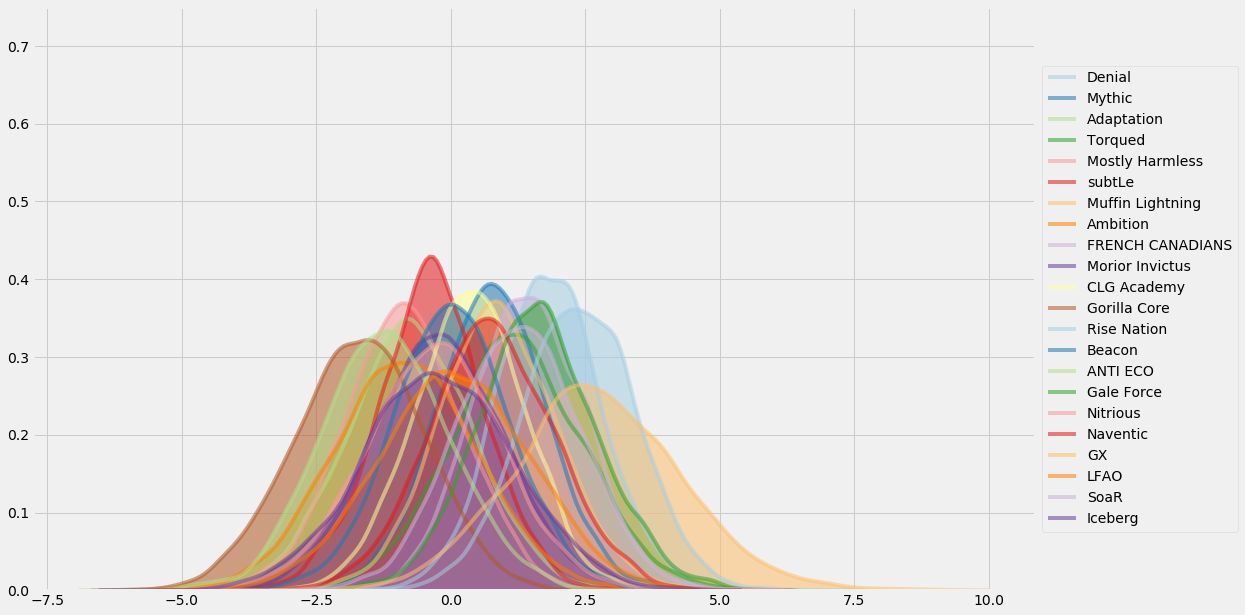

In [101]:
team_names = h_teams.loc[teams]
filt = team_names[team_names.Name.isin(FILTER_TEAMS)]
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,0.75)
[sns.kdeplot(trace['rating'][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

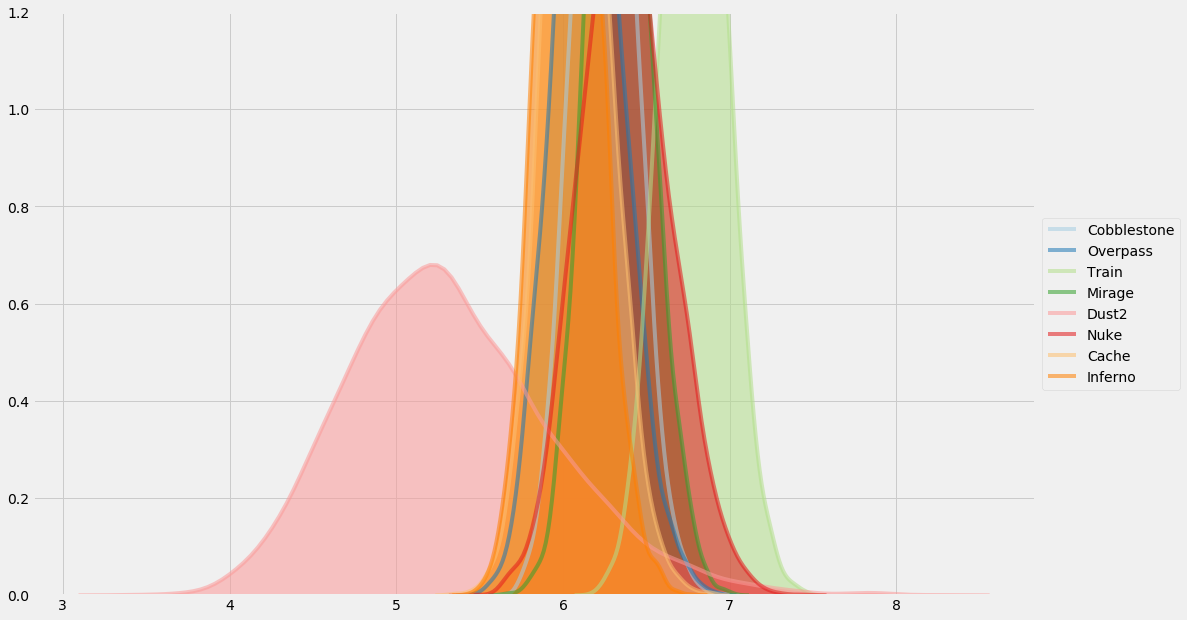

In [88]:
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,1.2)
[sns.kdeplot(trace['sigma'][:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=m) for i,m in enumerate(maps)]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

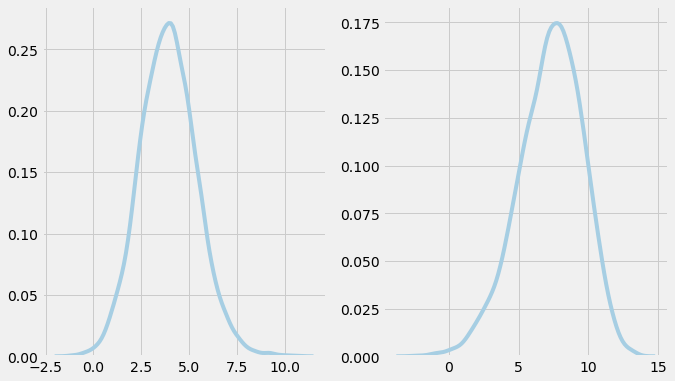

In [63]:
i = np.where(teams==7880)
j = np.where(teams==7924)

diff = (trace['rating'][:,j] - trace['rating'][:,i]).flatten()
kappa = 32./(1+np.exp(-1.*trace['alpha']*diff))-16.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
sns.kdeplot(kappa, ax=ax2)
sns.kdeplot(diff, ax=ax1)

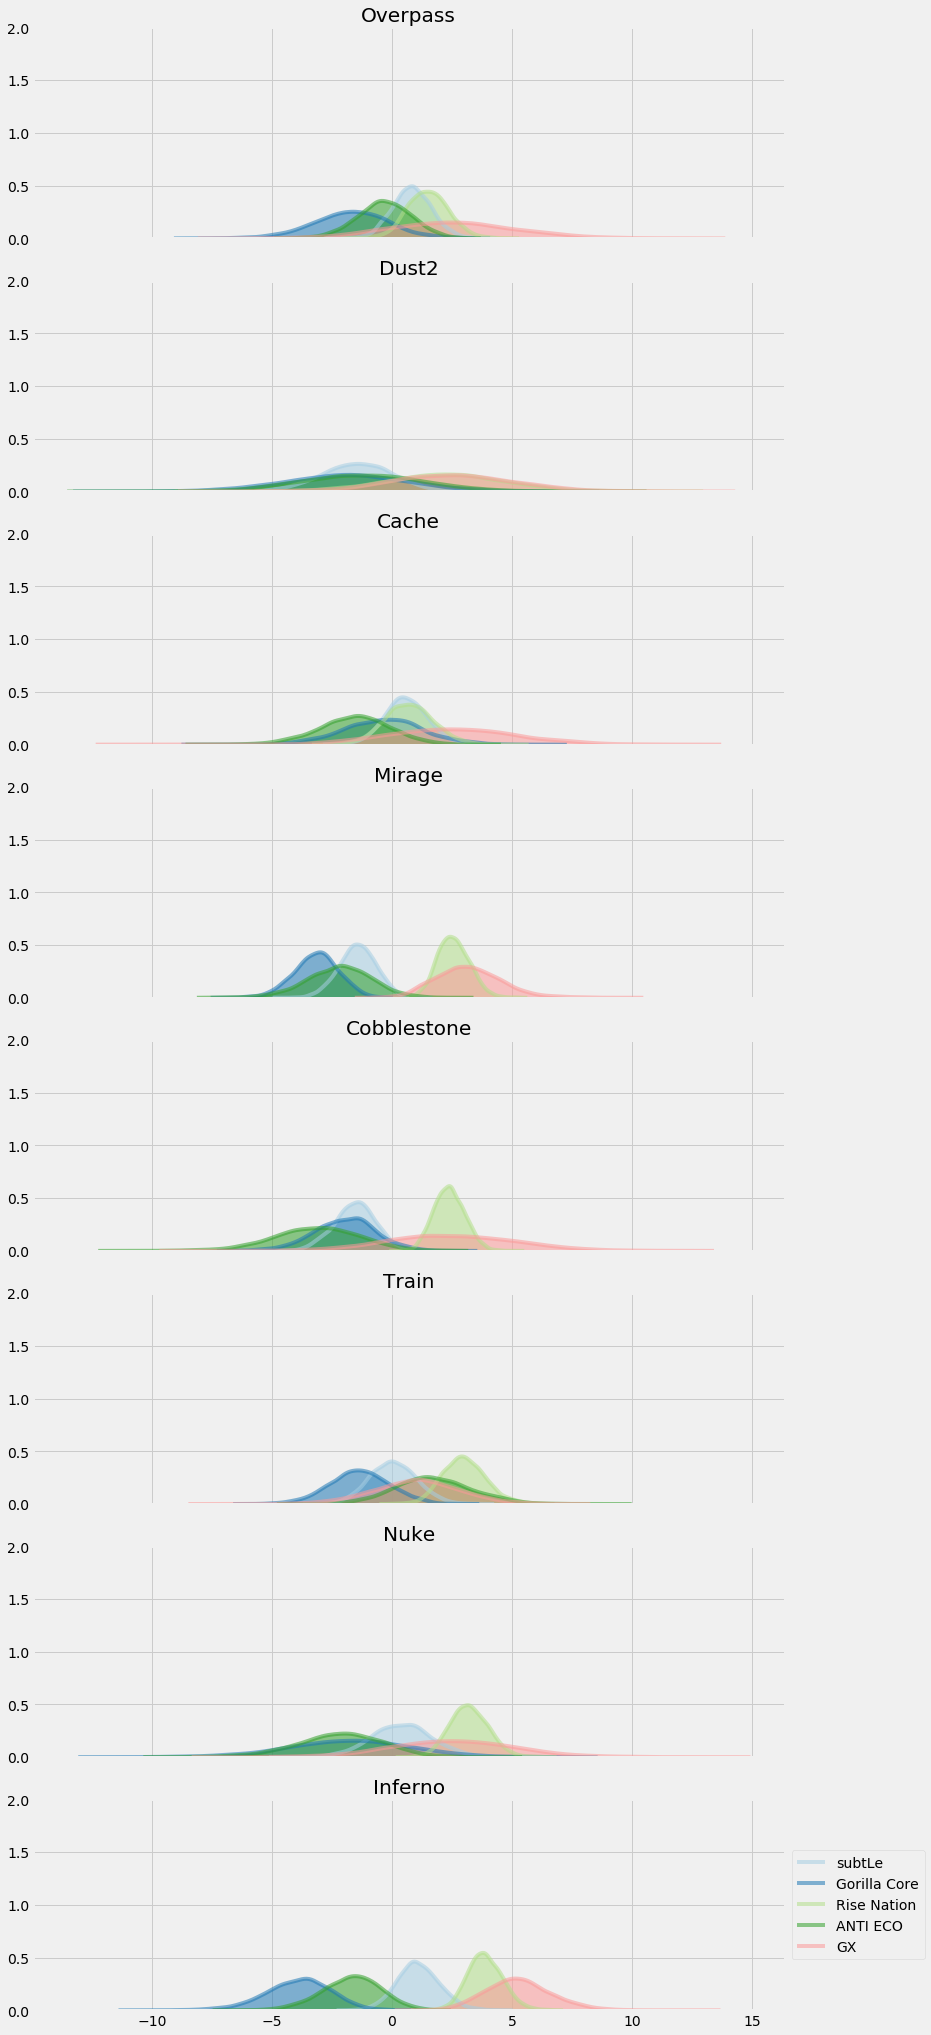

In [42]:
f, axes = plt.subplots(n_maps,1,figsize=(12,34), sharex=True)
for m, ax in enumerate(axes):
    ax.set_title(dict(enumerate(maps))[m])
    ax.set_ylim(0,2.0)
    [sns.kdeplot(trace['rating | map'][:,m,tmap[i]], shade=True, alpha=0.55, legend=False ,
                 ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save Model

In [115]:
EVENT_SET = 'eslpl'

pm.backends.text.dump('saved_model/'+EVENT_SET+'/trace', trace)
np.save('saved_model/'+EVENT_SET+'/teams.npy', teams)
np.save('saved_model/'+EVENT_SET+'/maps.npy', maps)
np.save('saved_model/'+EVENT_SET+'/filter_teams.npy', FILTER_TEAMS)

## Diagnostics

In [ ]:
with rating_model:
    approx = pm.fit(15000)
    ap_trace = approx.sample(5000)

In [ ]:
print('Gelman Rubin: %s' % pm.diagnostics.gelman_rubin(trace))
print('Effective N: %s' % pm.diagnostics.effective_n(trace))
print('Accept Prob: %.4f' % trace.get_sampler_stats('mean_tree_accept').mean())
print('Percentage of Divergent %.5f' % (trace['diverging'].nonzero()[0].size/float(len(trace))))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A8A9AD9320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001A8B44D2780>]], dtype=object)

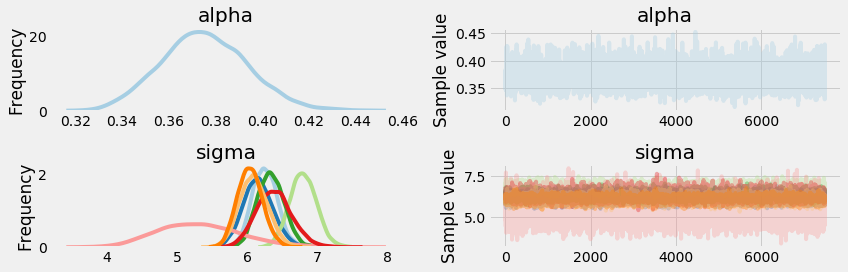

In [114]:
pm.traceplot(trace, varnames=['alpha', 'sigma'])

## Non-MCMC Model

In [ ]:
def vec2dict(s, n_teams):
    return {
        'mu': np.array(s[:n_teams]),
        'sigma': np.array(s[n_teams:n_teams*2]),
        'beta': s[-1],
    }

def dict2vec(s):
    return s['mu'] + s['sigma'] + [s['beta']]

In [ ]:
skills_0 = dict2vec({
    'mu': [1000]*n_teams,
    'sigma': [300]*n_teams,
    'beta': 50
})

In [ ]:
from scipy.optimize import minimize


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1-y)*np.log(1.-p)))

def obj(skills):
    s = vec2dict(skills, n_teams)
    mean_diff = s['mu'][obs['Team 1 ID'].map(tmap).values] - s['mu'][obs['Team 2 ID'].map(tmap).values]
    var_diff = s['sigma'][obs['Team 1 ID'].map(tmap).values]**2 + s['sigma'][obs['Team 2 ID'].map(tmap).values]**2 + skills[-1]**2
    p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
    return loglike((obs['Team 1 ID'] == obs['winner']).values, p)


In [ ]:
obj(skills_0)

In [ ]:
opt_skill = g.x
print(opt_skill)
plots = norm.rvs(opt_skill[:5], opt_skill[5:-1], size=(2000,5))

f, ax = plt.subplots(figsize=(12,8))
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]